In [1]:
# 시뮬레이션 라이브러리 불러오기 4_core_4129.5856 s
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import pickle
import sys


In [2]:
# 물질 설정 및 Refractive Index 설정
mp.verbosity(1)
um_scale = 2
seed = 240  # 난수 발생 시드(seed)를 240으로 설정 (재현성을 위해 난수 시드를 고정)
np.random.seed(seed)  # numpy의 난수 생성기의 시드를 설정하여 난수의 재현성 보장

Air = mp.Medium(index=1.0)
SiN = mp.Medium(epsilon=4)
SiO2 = mp.Medium(epsilon=2.1)
SiPD = mp.Medium(epsilon=5)

In [3]:
resolution = 25 # 해상도
design_region_width = 3 # 디자인 영역 너비
design_region_height = 4 # 디자인 영역 높이
pml_size = 1 # PML 영역 크기

In [4]:
structure_weight = np.loadtxt('lastdesign.txt')

n = 2000

zero_indices = np.where(structure_weight == 0)[0]
selected_indices = np.random.choice(zero_indices, size=n, replace=False)

structure_weight[selected_indices] = 0.25

In [5]:
# 시뮬레이션 공간 설정
Sx = design_region_width 
Sy = 2 * pml_size + design_region_height + 2
cell_size = mp.Vector3(Sx, Sy)

In [6]:
# 파장, 주파수 설정
wavelengths = np.array([0.43*um_scale, 0.45*um_scale, 0.47*um_scale, 0.53*um_scale, 0.55*um_scale, 0.57*um_scale, 0.62*um_scale, 0.65*um_scale, 0.68*um_scale])
frequencies = 1/wavelengths
nf = len(frequencies) # number of frequencies

In [7]:
minimum_length = 0.05  # minimum length scale (microns)
eta_i = 0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)
design_region_resolution = int(resolution)

In [8]:
pml_layers = [mp.PML(thickness = pml_size, direction = mp.Y)]

In [9]:
width = 0.1
fcen_red0 = frequencies[6]
fwidth_red0 = width * fcen_red0
fcen_red1 = frequencies[7]
fwidth_red1 = width * fcen_red1
fcen_red2 = frequencies[8]
fwidth_red2 = width * fcen_red2

fcen_green0 = frequencies[3]
fwidth_green0 = width * fcen_green0
fcen_green1 = frequencies[4]
fwidth_green1 = width * fcen_green1
fcen_green2 = frequencies[5]
fwidth_green2 = width * fcen_green2

fcen_blue0 = frequencies[0]
fwidth_blue0 = width * fcen_blue0
fcen_blue1 = frequencies[1]
fwidth_blue1 = width * fcen_blue1
fcen_blue2 = frequencies[2]
fwidth_blue2 = width * fcen_blue2

In [10]:
source_center = [0, Sy / 2 - pml_size - 0.5, 0] # Source 위치
source_size = mp.Vector3(Sx , 0, 0)

src_0 = mp.GaussianSource(frequency=fcen_red2, fwidth=fwidth_red2, is_integrated=True)
src_1 = mp.GaussianSource(frequency=fcen_red1, fwidth=fwidth_red1, is_integrated=True)
src_2 = mp.GaussianSource(frequency=fcen_red0, fwidth=fwidth_red0, is_integrated=True)
src_3 = mp.GaussianSource(frequency=fcen_green2, fwidth=fwidth_green2, is_integrated=True)
src_4 = mp.GaussianSource(frequency=fcen_green1, fwidth=fwidth_green1, is_integrated=True)
src_5 = mp.GaussianSource(frequency=fcen_green0, fwidth=fwidth_green0, is_integrated=True)
src_6 = mp.GaussianSource(frequency=fcen_blue2, fwidth=fwidth_blue2, is_integrated=True)
src_7 = mp.GaussianSource(frequency=fcen_blue1, fwidth=fwidth_blue1, is_integrated=True)
src_8 = mp.GaussianSource(frequency=fcen_blue0, fwidth=fwidth_blue0, is_integrated=True)

source = [mp.Source(src_0, component=mp.Ez, size=source_size, center=source_center),
          mp.Source(src_1, component=mp.Ez, size=source_size, center=source_center),
          mp.Source(src_2, component=mp.Ez, size=source_size, center=source_center),
          mp.Source(src_3, component=mp.Ez, size=source_size, center=source_center),
          mp.Source(src_4, component=mp.Ez, size=source_size, center=source_center),
          mp.Source(src_5, component=mp.Ez, size=source_size, center=source_center),
          mp.Source(src_6, component=mp.Ez, size=source_size, center=source_center),
          mp.Source(src_7, component=mp.Ez, size=source_size, center=source_center),
          mp.Source(src_8, component=mp.Ez, size=source_size, center=source_center)]


In [11]:
# 설계 영역의 픽셀 - 해상도와 디자인 영역에 따라 결정
Nx = int(round(design_region_resolution * design_region_width)) + 1
Ny = int(round(design_region_resolution * design_region_height)) + 1

# 설계 영역과 물질을 바탕으로 설계 영역 설정
design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), SiO2, SiN, grid_type="U_MEAN")

design_variables.update_weights(structure_weight)

design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(0, 0, 0),
        size=mp.Vector3(design_region_width, design_region_height, 0),
    ),
)

In [12]:
# filter.py conic_filter 함수와 simple_2d_filter 함수를 사용
def mapping(x, eta, beta):
    # filter
    x = x.flatten()
    
    filtered_field = mpa.conic_filter(
        x,
        filter_radius,
        design_region_width,
        design_region_height,
        design_region_resolution,
    )

    # projection
    # 출력값 -1 ~ 1으로 제한
    projected_field = mpa.tanh_projection(filtered_field, beta, eta)

    # interpolate to actual materials
    return projected_field.flatten()

In [13]:
# design region과 동일한 size의 Block 생성
geometry = [
    mp.Block(
        center=design_region.center, size=design_region.size, material=design_variables
    ),
    mp.Block(
        center=mp.Vector3(0, -3, 0), size=mp.Vector3(Sx, 2, 0), material=SiPD
    ),
    # mp.Block(
    #     center=mp.Vector3(-1, -3, 0), size=mp.Vector3(0.5, 2, 0), material=SiPD
    # ),
    # mp.Block(
    #     center=mp.Vector3(0, -3, 0), size=mp.Vector3(0.5, 2, 0), material=SiPD
    # ),
    # mp.Block(
    #     center=mp.Vector3(1, -3, 0), size=mp.Vector3(0.5, 2, 0), material=SiPD
    # )
]

In [14]:
# Meep simulation 세팅
sim = mp.Simulation(
    cell_size=cell_size, # cell_size = mp.Vector3(Sx, Sy)
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air, # 빈공간
    resolution=resolution,
    extra_materials=[SiN],
    k_point = mp.Vector3(0,0,0)
)

In [15]:
# 모니터 위치와 크기 설정 (focal point)
monitor_position_0, monitor_size_0 = mp.Vector3(-1, -2 - 0.5/resolution), mp.Vector3(0.01,0) 
monitor_position_1, monitor_size_1 = mp.Vector3(0, -2 - 0.5/resolution), mp.Vector3(0.01,0) 
monitor_position_2, monitor_size_2 = mp.Vector3(1, -2 - 0.5/resolution), mp.Vector3(0.01,0)

In [16]:
# FourierFields를 통해 monitor_position에서 monitor_size만큼의 영역에 대한 Fourier transform을 구함
FourierFields_0 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_0,size=monitor_size_0),mp.Ez,yee_grid=True)
FourierFields_1 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_0,size=monitor_size_0),mp.Ez,yee_grid=True)
FourierFields_2 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_0,size=monitor_size_0),mp.Ez,yee_grid=True)
FourierFields_3 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_1,size=monitor_size_1),mp.Ez,yee_grid=True)
FourierFields_4 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_1,size=monitor_size_1),mp.Ez,yee_grid=True)
FourierFields_5 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_1,size=monitor_size_1),mp.Ez,yee_grid=True)
FourierFields_6 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_2,size=monitor_size_2),mp.Ez,yee_grid=True)
FourierFields_7 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_2,size=monitor_size_2),mp.Ez,yee_grid=True)
FourierFields_8 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_2,size=monitor_size_2),mp.Ez,yee_grid=True)
ob_list = [FourierFields_0, FourierFields_1, FourierFields_2,FourierFields_3, FourierFields_4, FourierFields_5 ,FourierFields_6, FourierFields_7, FourierFields_8]


In [17]:
# J : Objective function
# FourierFields가 측정한 필드, 모니터의 중심에서 Ez 구성요소의 절댓값을 제곱한 값을 취한 후 평균을 계산하여 평균 강도를 계산
def J_0(fields_0, fields_1, fields_2,fields_3, fields_4, fields_5,fields_6, fields_7, fields_8):
    return npa.abs(fields_8[0,1]) ** 2 + npa.abs(fields_7[1,1]) ** 2 + npa.abs(fields_6[2,1]) ** 2 + npa.abs(fields_5[3,1]) ** 2 + npa.abs(fields_4[4,1]) ** 2 + npa.abs(fields_3[5,1]) ** 2 + npa.abs(fields_2[6,1]) ** 2 + npa.abs(fields_1[7,1]) ** 2 + npa.abs(fields_0[8,1]) ** 2
    # return npa.mean(npa.abs(fields[0,:]) ** 2)
# def J_1(fields):
#     return npa.mean(npa.abs(fields[1,:]) ** 2) 
# def J_2(fields):
#     return npa.mean(npa.abs(fields[2,:]) ** 2)

     block, center = (0,0,0)
          size (3,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-3,0)
          size (3,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5,5,5)


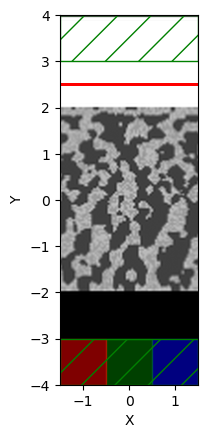

In [18]:
opt = mpa.OptimizationProblem(
    simulation=sim,
    # objective_functions=[J_0, J_1, J_2],
    objective_functions=[J_0],
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=frequencies,
    decay_by=1e-1,
)
plt.fill([Sx/6, Sx/6, Sx/2, Sx/2], [-Sy/2, -Sy/2+pml_size, -Sy/2+pml_size, -Sy/2], color='blue', alpha=0.5)
plt.fill([-Sx/6, -Sx/6, Sx/6, Sx/6], [-Sy/2, -Sy/2+pml_size, -Sy/2+pml_size, -Sy/2], color='green', alpha=0.5)
plt.fill([-Sx/2, -Sx/2, -Sx/6, -Sx/6], [-Sy/2, -Sy/2+pml_size, -Sy/2+pml_size, -Sy/2], color='red', alpha=0.5)
opt.plot2D(False)
plt.savefig("Lastdesign.png")

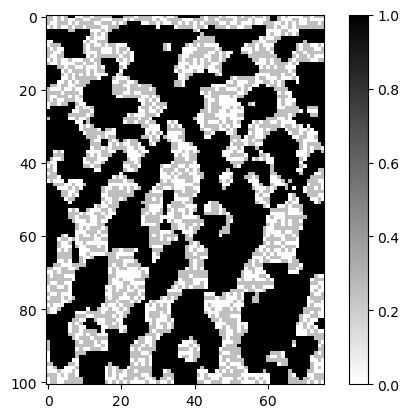

In [19]:
plt.imshow(npa.rot90(design_variables.weights.reshape(Nx, Ny)), cmap='binary')
plt.colorbar()
plt.savefig("Design.png")

In [20]:
evaluation_history = []
cur_iter = [0]

def f(v, gradient, beta):
    print("Current iteration: {}".format(cur_iter[0] + 1))

    f0, dJ_du = opt([mapping(v, eta_i, beta)])  # compute objective and gradient
    # f0, dJ_du = opt()
    
    # Adjoint gradient
    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping, 0)(
            v, eta_i, beta, np.sum(dJ_du, axis=1)
        )  # backprop

    evaluation_history.append(np.real(f0))

    plt.figure()
    ax = plt.gca()
    opt.plot2D(
        False,
        ax=ax,
        plot_sources_flag=False,
        plot_monitors_flag=False,
        plot_boundaries_flag=False,
    )
    circ = Circle((2, 2), minimum_length / 2)
    ax.add_patch(circ)
    ax.axis("off")
    plt.show()

    cur_iter[0] = cur_iter[0] + 1

    return np.real(f0)

-----------
Initializing structure...
time for choose_chunkdivision = 3.31402e-05 s
Working in 2D dimensions.
Computational cell is 3 x 8 x 0 with resolution 25
     block, center = (0,0,0)
          size (3,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-3,0)
          size (3,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5,5,5)
time for set_epsilon = 0.206417 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

run 0 finished at t = 300.0 (15000 timesteps)
     block, center = (0,0,0)
          size (3,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-3,0)
          size (3,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5,5,5)
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 2D dimensions.
Computational cell is 3 x 8 x 0 with resolution 25
     block, center = (0,0,0)
          size (3,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-3,0)
          size (3,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5,5,5)
time for set_epsilon = 0.20748 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

run 0 finished at t = 300.0 (15000 timesteps)
     block, center = (0,0,0)
          size (3,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-3,0)
          size (3,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5,5,5)
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 2D dimensions.
Computational cell is 3 x 8 x 0 with resolution 25
     block, center = (0,0,0)
          size (3,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-3,0)
          size (3,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5,5,5)
time for set_epsilon = 0.214047 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

run 0 finished at t = 300.0 (15000 timesteps)
     block, center = (0,0,0)
          size (3,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-3,0)
          size (3,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5,5,5)


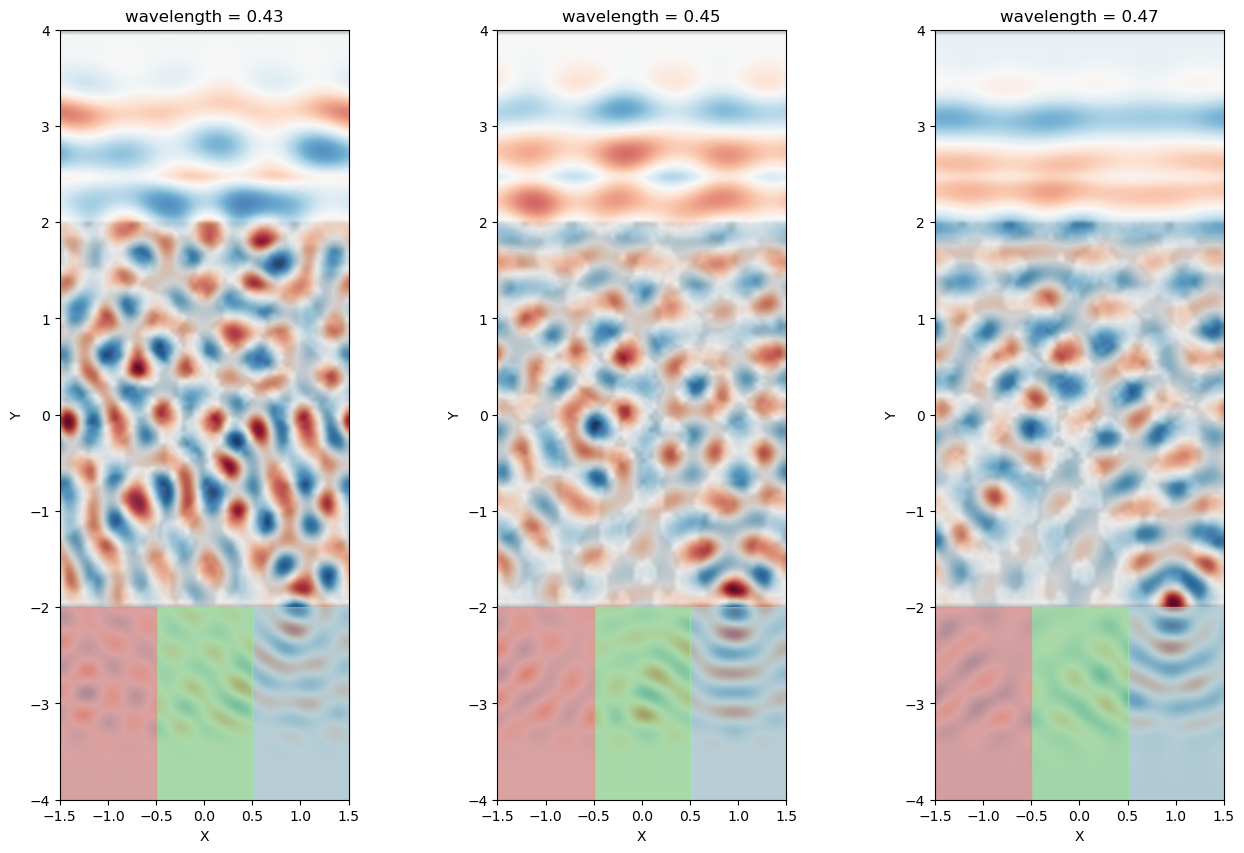

In [21]:
# z plane에서의 Ez field plot

opt.sim = mp.Simulation(
    cell_size=mp.Vector3(Sx, Sy),
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
    extra_materials=[SiN],
    k_point = mp.Vector3(0,0,0)
)
src = mp.ContinuousSource(frequency=frequencies[0], fwidth=fwidth_blue0, is_integrated=True)
source = [mp.Source(src, component=mp.Ez, size=source_size, center=source_center, )]
opt.sim.change_sources(source)

plt.figure(figsize=(16, 10))

plt.subplot(1,3,1)
plt.title('wavelength = '+str(wavelengths[0]/um_scale))
opt.sim.run(until=300)
plt.fill([Sx/6, Sx/6, Sx/2, Sx/2], [-Sy/2, -Sy/2+pml_size+1, -Sy/2+pml_size+1, -Sy/2], color='lightblue', alpha=0.5)
plt.fill([-Sx/6, -Sx/6, Sx/6, Sx/6], [-Sy/2, -Sy/2+pml_size+1, -Sy/2+pml_size+1, -Sy/2], color='lightgreen', alpha=0.5)
plt.fill([-Sx/2, -Sx/2, -Sx/6, -Sx/6], [-Sy/2, -Sy/2+pml_size+1, -Sy/2+pml_size+1, -Sy/2], color='lightcoral', alpha=0.5)
opt.sim.plot2D(fields=mp.Ez,
               source_parameters={'alpha':0},
               boundary_parameters={'alpha':0})
opt.sim.reset_meep()

opt.sim = mp.Simulation(
    cell_size=mp.Vector3(Sx, Sy),
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
    extra_materials=[SiN],
    k_point = mp.Vector3(0,0,0)
)

src = mp.ContinuousSource(frequency=frequencies[1], fwidth=fwidth_blue1, is_integrated=True)
source = [mp.Source(src, component=mp.Ez, size=source_size, center=source_center)]
opt.sim.change_sources(source)

plt.subplot(1,3,2)
plt.title('wavelength = '+str(wavelengths[1]/um_scale))
opt.sim.run(until=300)
plt.fill([Sx/6, Sx/6, Sx/2, Sx/2], [-Sy/2, -Sy/2+pml_size+1, -Sy/2+pml_size+1, -Sy/2], color='lightblue', alpha=0.5)
plt.fill([-Sx/6, -Sx/6, Sx/6, Sx/6], [-Sy/2, -Sy/2+pml_size+1, -Sy/2+pml_size+1, -Sy/2], color='lightgreen', alpha=0.5)
plt.fill([-Sx/2, -Sx/2, -Sx/6, -Sx/6], [-Sy/2, -Sy/2+pml_size+1, -Sy/2+pml_size+1, -Sy/2], color='lightcoral', alpha=0.5)
opt.sim.plot2D(fields=mp.Ez,
               source_parameters={'alpha':0},
               boundary_parameters={'alpha':0})
opt.sim.reset_meep()

opt.sim = mp.Simulation(
    cell_size=mp.Vector3(Sx, Sy),
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
    extra_materials=[SiN],
    k_point = mp.Vector3(0,0,0)
)

src = mp.ContinuousSource(frequency=frequencies[2], fwidth=fwidth_blue2, is_integrated=True)
source = [mp.Source(src, component=mp.Ez, size=source_size, center=source_center)]
opt.sim.change_sources(source)

plt.subplot(1,3,3)
plt.title('wavelength = '+str(wavelengths[2]/um_scale))
opt.sim.run(until=300)
plt.fill([Sx/6, Sx/6, Sx/2, Sx/2], [-Sy/2, -Sy/2+pml_size+1, -Sy/2+pml_size+1, -Sy/2], color='lightblue', alpha=0.5)
plt.fill([-Sx/6, -Sx/6, Sx/6, Sx/6], [-Sy/2, -Sy/2+pml_size+1, -Sy/2+pml_size+1, -Sy/2], color='lightgreen', alpha=0.5)
plt.fill([-Sx/2, -Sx/2, -Sx/6, -Sx/6], [-Sy/2, -Sy/2+pml_size+1, -Sy/2+pml_size+1, -Sy/2], color='lightcoral', alpha=0.5)
opt.sim.plot2D(fields=mp.Ez,
               source_parameters={'alpha':0},
               boundary_parameters={'alpha':0})
plt.savefig("EzBlue.png")

-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 2D dimensions.
Computational cell is 3 x 8 x 0 with resolution 25
     block, center = (0,0,0)
          size (3,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-3,0)
          size (3,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5,5,5)
time for set_epsilon = 0.213843 s
-----------
field decay(t = 10.02): 2.748851394929956e-14 / 2.748851394929956e-14 = 1.0
field decay(t = 20.04): 1.3177927466314452e-08 / 1.3177927466314452e-08 = 1.0
field decay(t = 30.060000000000002): 2.784104269727911e-05 / 2.784104269727911e-05 = 1.0
field decay(t = 40.06): 0.004530183414470577 / 0.004530183414470577 = 1.0
field decay(t = 50.08): 0.033993601911208884 / 0.033993601911208884 = 1.0
field decay(t = 60.1): 0.051879697660116963 / 0.051879697660116963 = 1.0
field decay(t = 70.12): 0.06292516160226744 / 0.06292516160226744 = 1.0
field decay(t

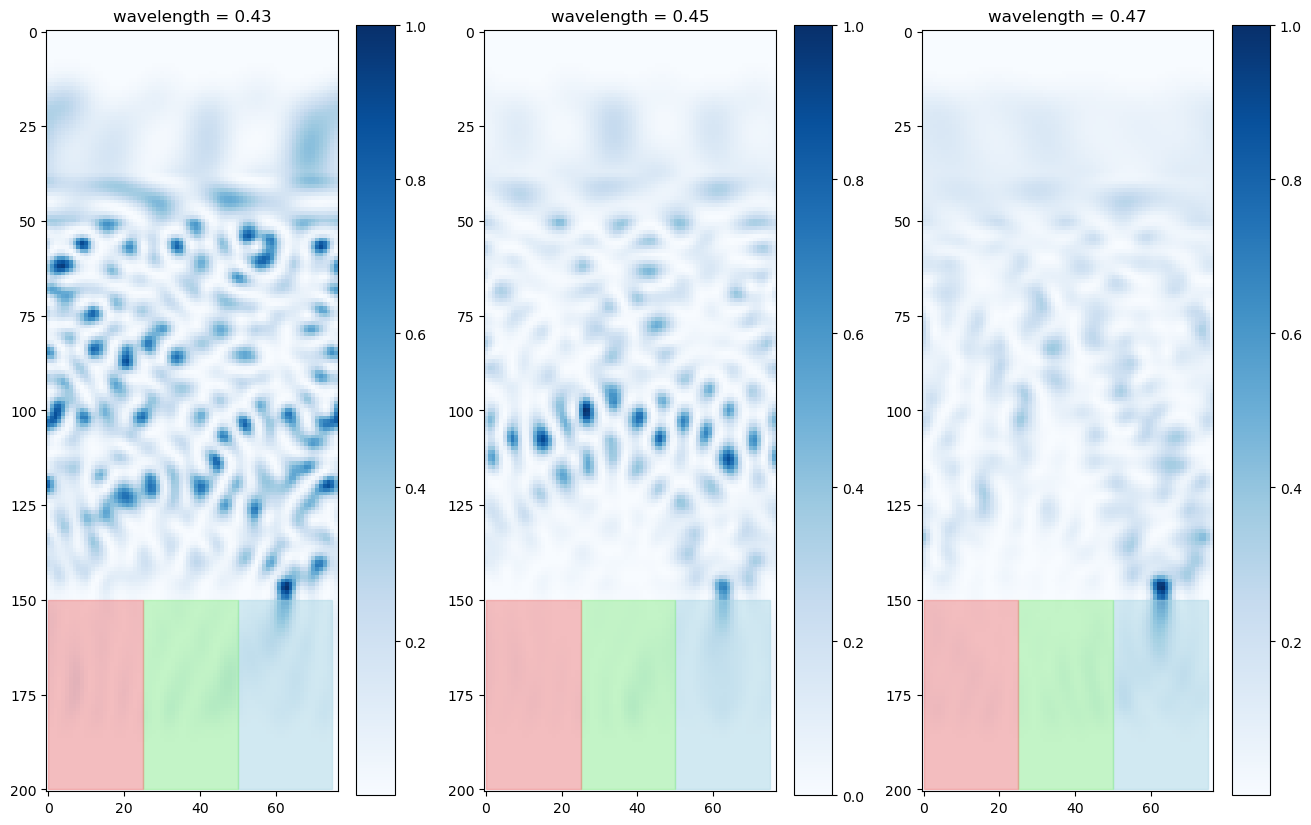

In [22]:

opt.sim = mp.Simulation(
    cell_size=mp.Vector3(Sx, Sy),
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
    extra_materials=[SiN],
    k_point = mp.Vector3(0,0,0)
)
src = mp.GaussianSource(frequency=frequencies[0], fwidth=fwidth_blue0, is_integrated=True)
source = [mp.Source(src, component=mp.Ez, size=source_size, center=source_center)]
opt.sim.change_sources(source)

plt.figure(figsize=(16, 10))

tran_total0 = opt.sim.add_dft_fields([mp.Ez], frequencies[0], 0 , 1, center=mp.Vector3(0, 0, 0), size=mp.Vector3(Sx, Sy, 0), yee_grid=True)

plt.subplot(1,3,1)
plt.title('wavelength = '+str(wavelengths[0]/um_scale))
pt = mp.Vector3(1, -Sy/2 + pml_size + 0.5/resolution, 0) #pt는 transmitted flux region과 동일


opt.sim.run(until_after_sources=mp.stop_when_fields_decayed(10,mp.Ez,pt,1e-3))
total_flux0 = np.abs(opt.sim.get_dft_array(tran_total0, mp.Ez, 0))**2
total_flux0 = (total_flux0 / total_flux0.max(axis=0).max(axis=0))

plt.imshow(npa.rot90(total_flux0.reshape(Sx* resolution+2, Sy* resolution+1)),cmap="Blues")
plt.fill([50, 50, 75, 75], [200, 150, 150, 200], color='lightblue', alpha=0.5)
plt.fill([25, 25, 50, 50], [200, 150, 150, 200], color='lightgreen', alpha=0.5)
plt.fill([0, 0, 25, 25], [200, 150, 150, 200], color='lightcoral', alpha=0.5)
plt.colorbar()
opt.sim.reset_meep()

opt.sim = mp.Simulation(
    cell_size=mp.Vector3(Sx, Sy),
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
    extra_materials=[SiN],
    k_point = mp.Vector3(0,0,0)
)

src = mp.GaussianSource(frequency=frequencies[1], fwidth=fwidth_blue1, is_integrated=True)
source = [mp.Source(src, component=mp.Ez, size=source_size, center=source_center)]
opt.sim.change_sources(source)

tran_total1 = opt.sim.add_dft_fields([mp.Ez], frequencies[1], 0 , 1, center=mp.Vector3(0, 0, 0), size=mp.Vector3(Sx, Sy, 0), yee_grid=True)


plt.subplot(1,3,2)
plt.title('wavelength = '+str(wavelengths[1]/um_scale))
pt = mp.Vector3(1, -Sy/2 + pml_size + 0.5/resolution, 0) #pt는 transmitted flux region과 동일


opt.sim.run(until_after_sources=mp.stop_when_fields_decayed(10,mp.Ez,pt,1e-3))
total_flux1 = np.abs(opt.sim.get_dft_array(tran_total1, mp.Ez, 0))**2
total_flux1 = (total_flux1 / total_flux1.max(axis=0).max(axis=0))

plt.imshow(npa.rot90(total_flux1.reshape(Sx* resolution+2, Sy* resolution+1)),cmap="Blues")
plt.fill([50, 50, 75, 75], [200, 150, 150, 200], color='lightblue', alpha=0.5)
plt.fill([25, 25, 50, 50], [200, 150, 150, 200], color='lightgreen', alpha=0.5)
plt.fill([0, 0, 25, 25], [200, 150, 150, 200], color='lightcoral', alpha=0.5)
plt.colorbar()
opt.sim.reset_meep()

opt.sim = mp.Simulation(
    cell_size=mp.Vector3(Sx, Sy),
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
    extra_materials=[SiN],
    k_point = mp.Vector3(0,0,0)
)

src = mp.GaussianSource(frequency=frequencies[2], fwidth=fwidth_blue2, is_integrated=True)
source = [mp.Source(src, component=mp.Ez, size=source_size, center=source_center)]
opt.sim.change_sources(source)

tran_total2 = opt.sim.add_dft_fields([mp.Ez], frequencies[2], 0 , 1, center=mp.Vector3(0, 0, 0), size=mp.Vector3(Sx, Sy, 0), yee_grid=True)

plt.subplot(1,3,3)
plt.title('wavelength = '+str(wavelengths[2]/um_scale))
pt = mp.Vector3(1, -Sy/2 + pml_size + 0.5/resolution, 0) #pt는 transmitted flux region과 동일


opt.sim.run(until_after_sources=mp.stop_when_fields_decayed(10,mp.Ez,pt,1e-3))
total_flux2 = np.abs(opt.sim.get_dft_array(tran_total2, mp.Ez, 0))**2
total_flux2 = (total_flux2 / total_flux2.max(axis=0).max(axis=0))

plt.imshow(npa.rot90(total_flux2.reshape(Sx* resolution+2, Sy* resolution+1)),cmap="Blues")
plt.fill([50, 50, 75, 75], [200, 150, 150, 200], color='lightblue', alpha=0.5)
plt.fill([25, 25, 50, 50], [200, 150, 150, 200], color='lightgreen', alpha=0.5)
plt.fill([0, 0, 25, 25], [200, 150, 150, 200], color='lightcoral', alpha=0.5)
plt.colorbar()
plt.savefig("IntensityBlue.png")

-----------
Initializing structure...
time for choose_chunkdivision = 2.88486e-05 s
Working in 2D dimensions.
Computational cell is 3 x 8 x 0 with resolution 25
     block, center = (0,0,0)
          size (3,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-3,0)
          size (3,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5,5,5)
time for set_epsilon = 0.20707 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

run 0 finished at t = 300.0 (15000 timesteps)
     block, center = (0,0,0)
          size (3,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-3,0)
          size (3,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5,5,5)
-----------
Initializing structure...
time for choose_chunkdivision = 2.88486e-05 s
Working in 2D dimensions.
Computational cell is 3 x 8 x 0 with resolution 25
     block, center = (0,0,0)
          size (3,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-3,0)
          size (3,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5,5,5)
time for set_epsilon = 0.212781 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

run 0 finished at t = 300.0 (15000 timesteps)
     block, center = (0,0,0)
          size (3,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-3,0)
          size (3,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5,5,5)
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 2D dimensions.
Computational cell is 3 x 8 x 0 with resolution 25
     block, center = (0,0,0)
          size (3,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-3,0)
          size (3,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5,5,5)
time for set_epsilon = 0.206317 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

run 0 finished at t = 300.0 (15000 timesteps)
     block, center = (0,0,0)
          size (3,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-3,0)
          size (3,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5,5,5)


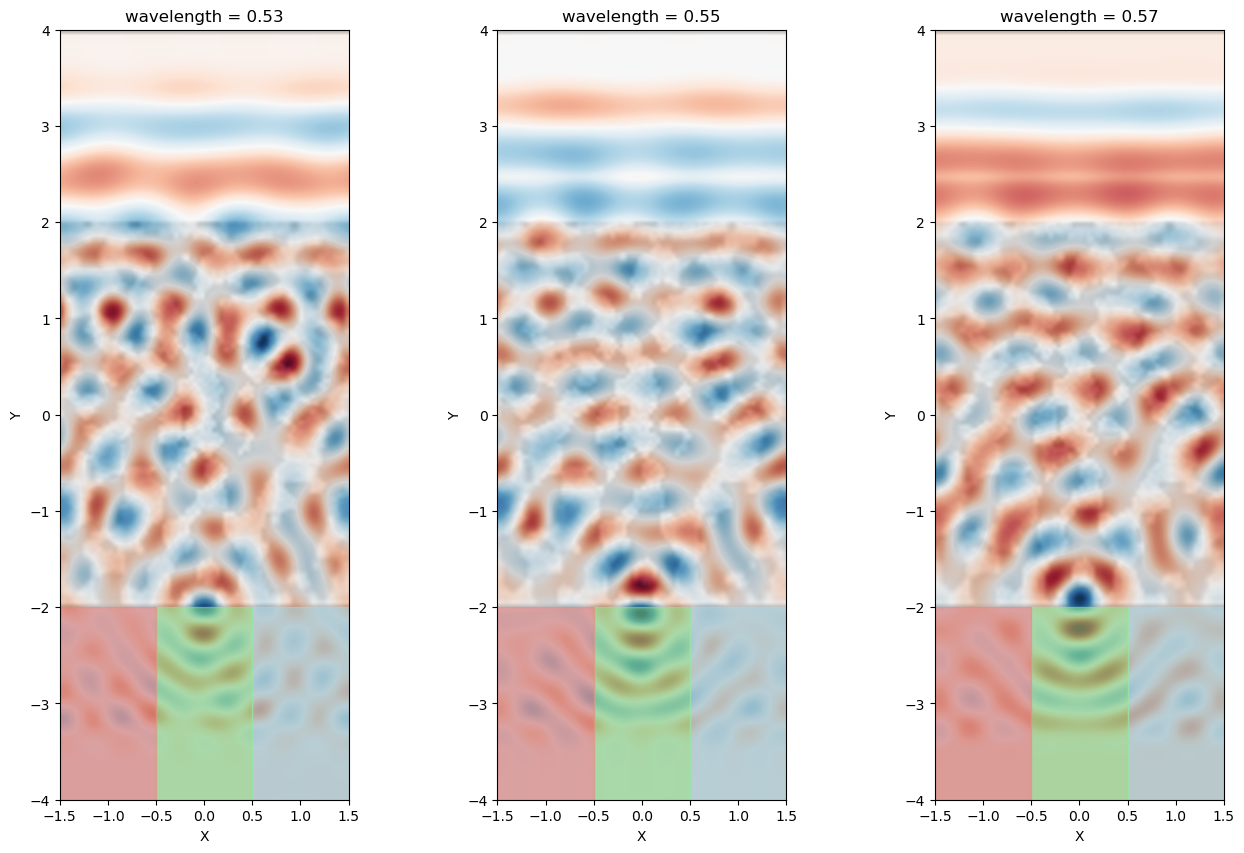

In [23]:
# z plane에서의 Ez field plot

opt.sim = mp.Simulation(
    cell_size=mp.Vector3(Sx, Sy),
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
    extra_materials=[SiN],
    k_point = mp.Vector3(0,0,0)
)
src = mp.ContinuousSource(frequency=frequencies[3], fwidth=fwidth_green0, is_integrated=True)
source = [mp.Source(src, component=mp.Ez, size=source_size, center=source_center)]
opt.sim.change_sources(source)

plt.figure(figsize=(16, 10))

plt.subplot(1,3,1)
plt.title('wavelength = '+str(wavelengths[3]/um_scale))
opt.sim.run(until=300)
plt.fill([Sx/6, Sx/6, Sx/2, Sx/2], [-Sy/2, -Sy/2+pml_size+1, -Sy/2+pml_size+1, -Sy/2], color='lightblue', alpha=0.5)
plt.fill([-Sx/6, -Sx/6, Sx/6, Sx/6], [-Sy/2, -Sy/2+pml_size+1, -Sy/2+pml_size+1, -Sy/2], color='lightgreen', alpha=0.5)
plt.fill([-Sx/2, -Sx/2, -Sx/6, -Sx/6], [-Sy/2, -Sy/2+pml_size+1, -Sy/2+pml_size+1, -Sy/2], color='lightcoral', alpha=0.5)
opt.sim.plot2D(fields=mp.Ez,
               source_parameters={'alpha':0},
               boundary_parameters={'alpha':0})
opt.sim.reset_meep()

opt.sim = mp.Simulation(
    cell_size=mp.Vector3(Sx, Sy),
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
    extra_materials=[SiN],
    k_point = mp.Vector3(0,0,0)
)

src = mp.ContinuousSource(frequency=frequencies[4], fwidth=fwidth_green1, is_integrated=True)
source = [mp.Source(src, component=mp.Ez, size=source_size, center=source_center)]
opt.sim.change_sources(source)

plt.subplot(1,3,2)
plt.title('wavelength = '+str(wavelengths[4]/um_scale))
opt.sim.run(until=300)
plt.fill([Sx/6, Sx/6, Sx/2, Sx/2], [-Sy/2, -Sy/2+pml_size+1, -Sy/2+pml_size+1, -Sy/2], color='lightblue', alpha=0.5)
plt.fill([-Sx/6, -Sx/6, Sx/6, Sx/6], [-Sy/2, -Sy/2+pml_size+1, -Sy/2+pml_size+1, -Sy/2], color='lightgreen', alpha=0.5)
plt.fill([-Sx/2, -Sx/2, -Sx/6, -Sx/6], [-Sy/2, -Sy/2+pml_size+1, -Sy/2+pml_size+1, -Sy/2], color='lightcoral', alpha=0.5)
opt.sim.plot2D(fields=mp.Ez,
               source_parameters={'alpha':0},
               boundary_parameters={'alpha':0})
opt.sim.reset_meep()

opt.sim = mp.Simulation(
    cell_size=mp.Vector3(Sx, Sy),
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
    extra_materials=[SiN],
    k_point = mp.Vector3(0,0,0)
)

src = mp.ContinuousSource(frequency=frequencies[5], fwidth=fwidth_green2, is_integrated=True)
source = [mp.Source(src, component=mp.Ez, size=source_size, center=source_center)]
opt.sim.change_sources(source)

plt.subplot(1,3,3)
plt.title('wavelength = '+str(wavelengths[5]/um_scale))
opt.sim.run(until=300)
plt.fill([Sx/6, Sx/6, Sx/2, Sx/2], [-Sy/2, -Sy/2+pml_size+1, -Sy/2+pml_size+1, -Sy/2], color='lightblue', alpha=0.5)
plt.fill([-Sx/6, -Sx/6, Sx/6, Sx/6], [-Sy/2, -Sy/2+pml_size+1, -Sy/2+pml_size+1, -Sy/2], color='lightgreen', alpha=0.5)
plt.fill([-Sx/2, -Sx/2, -Sx/6, -Sx/6], [-Sy/2, -Sy/2+pml_size+1, -Sy/2+pml_size+1, -Sy/2], color='lightcoral', alpha=0.5)
opt.sim.plot2D(fields=mp.Ez,
               source_parameters={'alpha':0},
               boundary_parameters={'alpha':0})
plt.savefig("EzGreen.png")

-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 2D dimensions.
Computational cell is 3 x 8 x 0 with resolution 25
     block, center = (0,0,0)
          size (3,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-3,0)
          size (3,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5,5,5)
time for set_epsilon = 0.207566 s
-----------
field decay(t = 10.02): 1.340773001190849e-13 / 1.340773001190849e-13 = 1.0
field decay(t = 20.04): 3.1348898259164525e-09 / 3.1348898259164525e-09 = 1.0
field decay(t = 30.060000000000002): 3.0483231621158377e-06 / 3.0483231621158377e-06 = 1.0
field decay(t = 40.06): 0.0005104887585302873 / 0.0005104887585302873 = 1.0
field decay(t = 50.08): 0.013731331780799235 / 0.013731331780799235 = 1.0
field decay(t = 60.1): 0.08649203559653468 / 0.08649203559653468 = 1.0
field decay(t = 70.12): 0.1219023286152088 / 0.1219023286152088 = 1.0
field decay(t

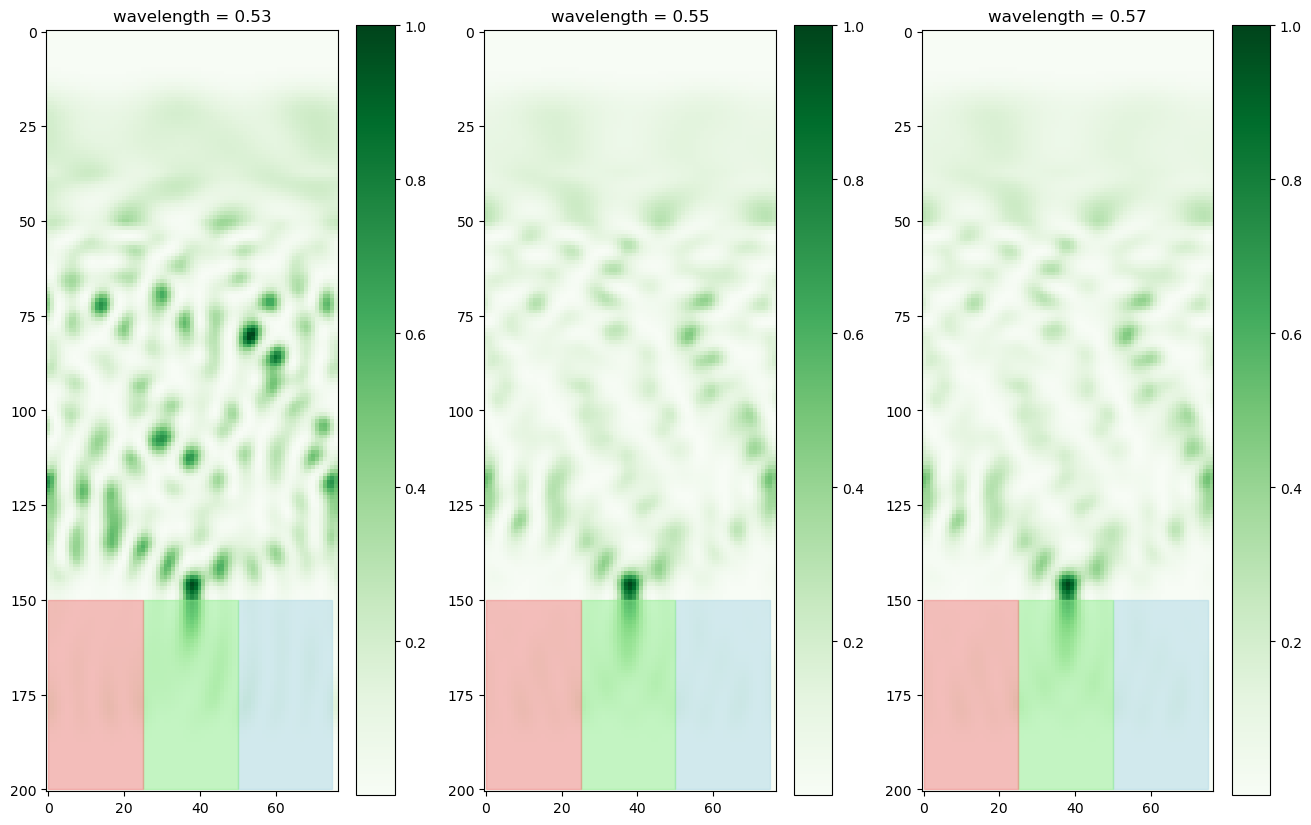

In [24]:
opt.sim = mp.Simulation(
    cell_size=mp.Vector3(Sx, Sy),
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
    extra_materials=[SiN],
    k_point = mp.Vector3(0,0,0)
)
src = mp.GaussianSource(frequency=frequencies[3], fwidth=fwidth_green0, is_integrated=True)
source = [mp.Source(src, component=mp.Ez, size=source_size, center=source_center, amplitude = 1.405765992)]
opt.sim.change_sources(source)

plt.figure(figsize=(16, 10))

tran_total3 = opt.sim.add_dft_fields([mp.Ez], frequencies[3], 0 , 1, center=mp.Vector3(0, 0, 0), size=mp.Vector3(Sx, Sy, 0), yee_grid=True)
plt.subplot(1,3,1)
plt.title('wavelength = '+str(wavelengths[3]/um_scale))
pt = mp.Vector3(1, -Sy/2 + pml_size + 0.5/resolution, 0) #pt는 transmitted flux region과 동일

opt.sim.run(until_after_sources=mp.stop_when_fields_decayed(10,mp.Ez,pt,1e-3))
total_flux3 = np.abs(opt.sim.get_dft_array(tran_total3, mp.Ez, 0)) ** 2
total_flux3 = (total_flux3 / total_flux3.max(axis=0).max(axis=0))

plt.imshow(npa.rot90(total_flux3.reshape(Sx* resolution+2, Sy* resolution+1)), cmap="Greens")
plt.fill([50, 50, 75, 75], [200, 150, 150, 200], color='lightblue', alpha=0.5)
plt.fill([25, 25, 50, 50], [200, 150, 150, 200], color='lightgreen', alpha=0.5)
plt.fill([0, 0, 25, 25], [200, 150, 150, 200], color='lightcoral', alpha=0.5)
plt.colorbar()
opt.sim.reset_meep()

opt.sim = mp.Simulation(
    cell_size=mp.Vector3(Sx, Sy),
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
    extra_materials=[SiN],
    k_point = mp.Vector3(0,0,0)
)

src = mp.GaussianSource(frequency=frequencies[4], fwidth=fwidth_green1, is_integrated=True)
source = [mp.Source(src, component=mp.Ez, size=source_size, center=source_center, amplitude = 1.329122323)]
opt.sim.change_sources(source)

tran_total4 = opt.sim.add_dft_fields([mp.Ez], frequencies[4], 0 , 1, center=mp.Vector3(0, 0, 0), size=mp.Vector3(Sx, Sy, 0), yee_grid=True)
plt.subplot(1,3,2)
plt.title('wavelength = '+str(wavelengths[4]/um_scale))
pt = mp.Vector3(1, -Sy/2 + pml_size + 0.5/resolution, 0) #pt는 transmitted flux region과 동일

opt.sim.run(until_after_sources=mp.stop_when_fields_decayed(10,mp.Ez,pt,1e-3))
total_flux4 = np.abs(opt.sim.get_dft_array(tran_total4, mp.Ez, 0)) ** 2
total_flux4 = (total_flux4 / total_flux4.max(axis=0).max(axis=0))

plt.imshow(npa.rot90(total_flux4.reshape(Sx* resolution+2, Sy* resolution+1)), cmap="Greens")
plt.fill([50, 50, 75, 75], [200, 150, 150, 200], color='lightblue', alpha=0.5)
plt.fill([25, 25, 50, 50], [200, 150, 150, 200], color='lightgreen', alpha=0.5)
plt.fill([0, 0, 25, 25], [200, 150, 150, 200], color='lightcoral', alpha=0.5)
plt.colorbar()
opt.sim.reset_meep()

opt.sim = mp.Simulation(
    cell_size=mp.Vector3(Sx, Sy),
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
    extra_materials=[SiN],
    k_point = mp.Vector3(0,0,0)
)

src = mp.GaussianSource(frequency=frequencies[5], fwidth=fwidth_green2, is_integrated=True)
source = [mp.Source(src, component=mp.Ez, size=source_size, center=source_center, amplitude = 1.264200342)]
opt.sim.change_sources(source)

tran_total5 = opt.sim.add_dft_fields([mp.Ez], frequencies[5], 0 , 1, center=mp.Vector3(0, 0, 0), size=mp.Vector3(Sx, Sy, 0), yee_grid=True)
plt.subplot(1,3,3)
plt.title('wavelength = '+str(wavelengths[5]/um_scale))
pt = mp.Vector3(1, -Sy/2 + pml_size + 0.5/resolution, 0) #pt는 transmitted flux region과 동일

opt.sim.run(until_after_sources=mp.stop_when_fields_decayed(10,mp.Ez,pt,1e-3))
total_flux5 = np.abs(opt.sim.get_dft_array(tran_total5, mp.Ez, 0)) ** 2
total_flux5 = (total_flux5 / total_flux5.max(axis=0).max(axis=0))

plt.imshow(npa.rot90(total_flux4.reshape(Sx* resolution+2, Sy* resolution+1)), cmap="Greens")
plt.fill([50, 50, 75, 75], [200, 150, 150, 200], color='lightblue', alpha=0.5)
plt.fill([25, 25, 50, 50], [200, 150, 150, 200], color='lightgreen', alpha=0.5)
plt.fill([0, 0, 25, 25], [200, 150, 150, 200], color='lightcoral', alpha=0.5)
plt.colorbar()
plt.savefig("IntensityGreen.png")

-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 2D dimensions.
Computational cell is 3 x 8 x 0 with resolution 25
     block, center = (0,0,0)
          size (3,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-3,0)
          size (3,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5,5,5)
time for set_epsilon = 0.206623 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

run 0 finished at t = 300.0 (15000 timesteps)
     block, center = (0,0,0)
          size (3,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-3,0)
          size (3,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5,5,5)
-----------
Initializing structure...
time for choose_chunkdivision = 3.19481e-05 s
Working in 2D dimensions.
Computational cell is 3 x 8 x 0 with resolution 25
     block, center = (0,0,0)
          size (3,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-3,0)
          size (3,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5,5,5)
time for set_epsilon = 0.206417 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

run 0 finished at t = 300.0 (15000 timesteps)
     block, center = (0,0,0)
          size (3,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-3,0)
          size (3,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5,5,5)
-----------
Initializing structure...
time for choose_chunkdivision = 2.88486e-05 s
Working in 2D dimensions.
Computational cell is 3 x 8 x 0 with resolution 25
     block, center = (0,0,0)
          size (3,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-3,0)
          size (3,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5,5,5)
time for set_epsilon = 0.210102 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

run 0 finished at t = 300.0 (15000 timesteps)
     block, center = (0,0,0)
          size (3,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-3,0)
          size (3,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5,5,5)


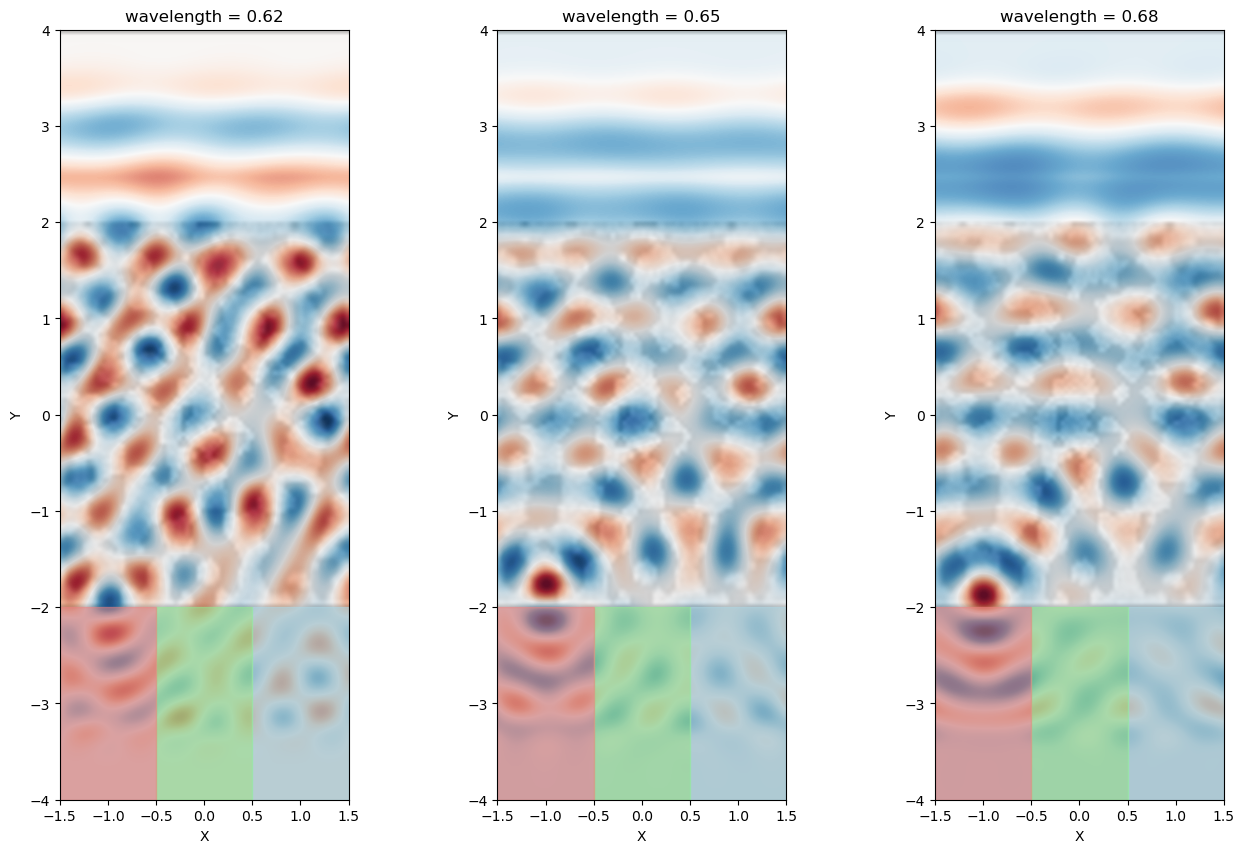

In [25]:
# z plane에서의 Ez field plot

opt.sim = mp.Simulation(
    cell_size=mp.Vector3(Sx, Sy),
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
    # extra_materials=[SiN],
    k_point = mp.Vector3(0,0,0)
)
src = mp.ContinuousSource(frequency=frequencies[6], fwidth=fwidth_red0, is_integrated=True)
source = [mp.Source(src, component=mp.Ez, size=source_size, center=source_center)]
opt.sim.change_sources(source)

plt.figure(figsize=(16, 10))

plt.subplot(1,3,1)
plt.title('wavelength = '+str(wavelengths[6]/um_scale))
opt.sim.run(until=300)
plt.fill([Sx/6, Sx/6, Sx/2, Sx/2], [-Sy/2, -Sy/2+pml_size+1, -Sy/2+pml_size+1, -Sy/2], color='lightblue', alpha=0.5)
plt.fill([-Sx/6, -Sx/6, Sx/6, Sx/6], [-Sy/2, -Sy/2+pml_size+1, -Sy/2+pml_size+1, -Sy/2], color='lightgreen', alpha=0.5)
plt.fill([-Sx/2, -Sx/2, -Sx/6, -Sx/6], [-Sy/2, -Sy/2+pml_size+1, -Sy/2+pml_size+1, -Sy/2], color='lightcoral', alpha=0.5)
opt.sim.plot2D(fields=mp.Ez,
               source_parameters={'alpha':0},
               boundary_parameters={'alpha':0})
opt.sim.reset_meep()

opt.sim = mp.Simulation(
    cell_size=mp.Vector3(Sx, Sy),
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
    # extra_materials=[SiN],
    k_point = mp.Vector3(0,0,0)
)

src = mp.ContinuousSource(frequency=frequencies[7], fwidth=fwidth_red1, is_integrated=True)
source = [mp.Source(src, component=mp.Ez, size=source_size, center=source_center)]
opt.sim.change_sources(source)

plt.subplot(1,3,2)
plt.title('wavelength = '+str(wavelengths[7]/um_scale))
opt.sim.run(until=300)
plt.fill([Sx/6, Sx/6, Sx/2, Sx/2], [-Sy/2, -Sy/2+pml_size+1, -Sy/2+pml_size+1, -Sy/2], color='lightblue', alpha=0.5)
plt.fill([-Sx/6, -Sx/6, Sx/6, Sx/6], [-Sy/2, -Sy/2+pml_size+1, -Sy/2+pml_size+1, -Sy/2], color='lightgreen', alpha=0.5)
plt.fill([-Sx/2, -Sx/2, -Sx/6, -Sx/6], [-Sy/2, -Sy/2+pml_size+1, -Sy/2+pml_size+1, -Sy/2], color='lightcoral', alpha=0.5)
opt.sim.plot2D(fields=mp.Ez,
               source_parameters={'alpha':0},
               boundary_parameters={'alpha':0})
opt.sim.reset_meep()

opt.sim = mp.Simulation(
    cell_size=mp.Vector3(Sx, Sy),
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
    # extra_materials=[SiN],
    k_point = mp.Vector3(0,0,0)
)

src = mp.ContinuousSource(frequency=frequencies[8], fwidth=fwidth_red2, is_integrated=True)
source = [mp.Source(src, component=mp.Ez, size=source_size, center=source_center)]
opt.sim.change_sources(source)

plt.subplot(1,3,3)
plt.title('wavelength = '+str(wavelengths[8]/um_scale))
opt.sim.run(until=300)
plt.fill([Sx/6, Sx/6, Sx/2, Sx/2], [-Sy/2, -Sy/2+pml_size+1, -Sy/2+pml_size+1, -Sy/2], color='lightblue', alpha=0.5)
plt.fill([-Sx/6, -Sx/6, Sx/6, Sx/6], [-Sy/2, -Sy/2+pml_size+1, -Sy/2+pml_size+1, -Sy/2], color='lightgreen', alpha=0.5)
plt.fill([-Sx/2, -Sx/2, -Sx/6, -Sx/6], [-Sy/2, -Sy/2+pml_size+1, -Sy/2+pml_size+1, -Sy/2], color='lightcoral', alpha=0.5)
opt.sim.plot2D(fields=mp.Ez,
               source_parameters={'alpha':0},
               boundary_parameters={'alpha':0})
plt.savefig("EzRed.png")

-----------
Initializing structure...
time for choose_chunkdivision = 2.98023e-05 s
Working in 2D dimensions.
Computational cell is 3 x 8 x 0 with resolution 25
     block, center = (0,0,0)
          size (3,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-3,0)
          size (3,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5,5,5)
time for set_epsilon = 0.207781 s
-----------
field decay(t = 10.02): 1.552430828321013e-13 / 1.552430828321013e-13 = 1.0
field decay(t = 20.04): 2.596580273881483e-10 / 2.596580273881483e-10 = 1.0
field decay(t = 30.060000000000002): 1.0752991157869657e-07 / 1.0752991157869657e-07 = 1.0
field decay(t = 40.06): 1.2571175890313813e-05 / 1.2571175890313813e-05 = 1.0
field decay(t = 50.08): 0.0004233934754876538 / 0.0004233934754876538 = 1.0
field decay(t = 60.1): 0.004753402896607919 / 0.004753402896607919 = 1.0
field decay(t = 70.12): 0.01675622265694732 / 0.01675622265694732 = 1.0
field d

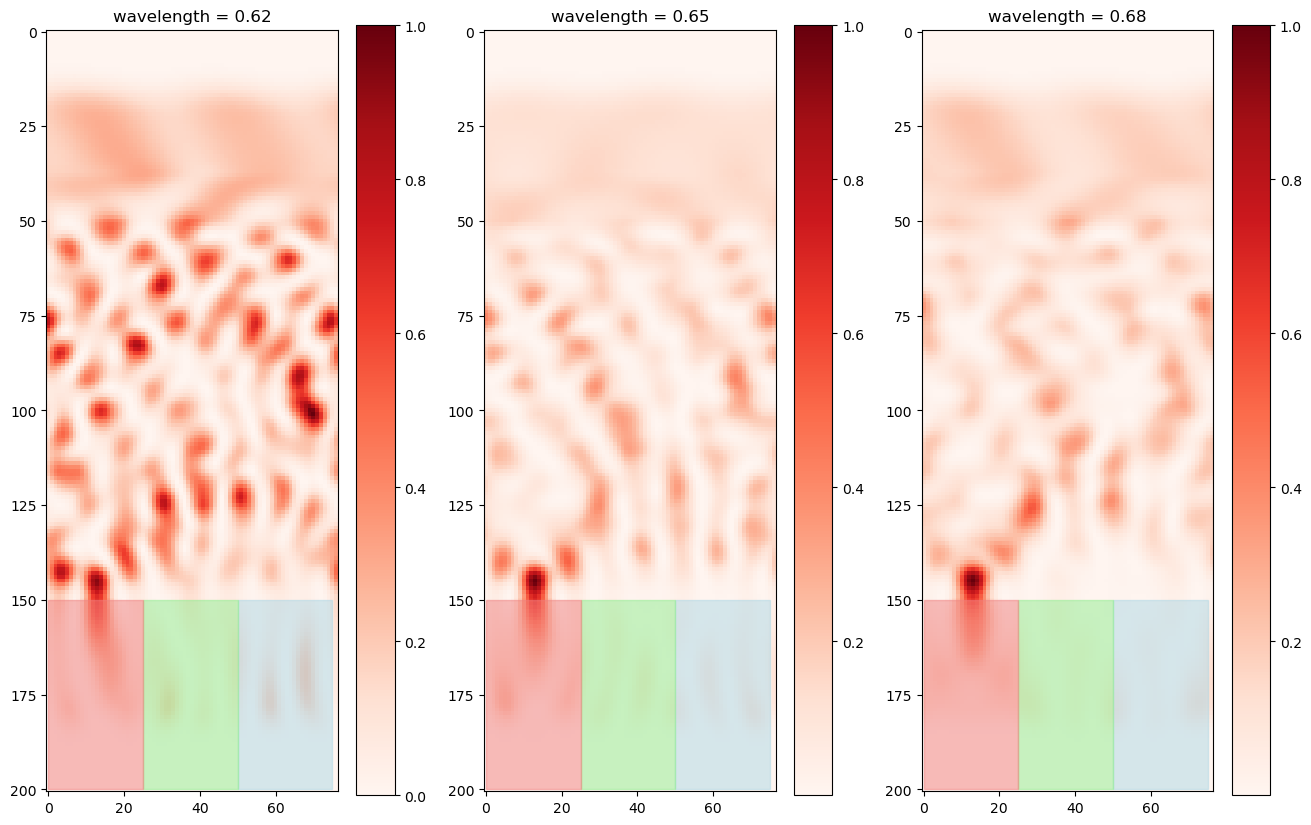

In [26]:
# z plane에서의 Ez field plot

opt.sim = mp.Simulation(
    cell_size=mp.Vector3(Sx, Sy),
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
    extra_materials=[SiN],
    k_point = mp.Vector3(0,0,0)
)
src = mp.GaussianSource(frequency=frequencies[6], fwidth=fwidth_red0, is_integrated=True)
source = [mp.Source(src, component=mp.Ez, size=source_size, center=source_center, amplitude = 1.123943214)]
opt.sim.change_sources(source)

plt.figure(figsize=(16, 10))

tran_total6 = opt.sim.add_dft_fields([mp.Ez], frequencies[6], 0 , 1, center=mp.Vector3(0, 0, 0), size=mp.Vector3(Sx, Sy, 0), yee_grid=True)
plt.subplot(1,3,1)
plt.title('wavelength = '+str(wavelengths[6]/um_scale))
pt = mp.Vector3(1, -Sy/2 + pml_size + 0.5/resolution, 0) #pt는 transmitted flux region과 동일

opt.sim.run(until_after_sources=mp.stop_when_fields_decayed(10,mp.Ez,pt,1e-3))
total_flux6 = np.abs(opt.sim.get_dft_array(tran_total6, mp.Ez, 0)) ** 2
total_flux6 = (total_flux6 / total_flux6.max(axis=0).max(axis=0))

plt.imshow(npa.rot90(total_flux6.reshape(Sx* resolution+2, Sy* resolution+1)), cmap="Reds")
plt.fill([50, 50, 75, 75], [200, 150, 150, 200], color='lightblue', alpha=0.5)
plt.fill([25, 25, 50, 50], [200, 150, 150, 200], color='lightgreen', alpha=0.5)
plt.fill([0, 0, 25, 25], [200, 150, 150, 200], color='lightcoral', alpha=0.5)
plt.colorbar()
opt.sim.reset_meep()

opt.sim = mp.Simulation(
    cell_size=mp.Vector3(Sx, Sy),
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
    extra_materials=[SiN],
    k_point = mp.Vector3(0,0,0)
)

src = mp.GaussianSource(frequency=frequencies[7], fwidth=fwidth_red1, is_integrated=True)
source = [mp.Source(src, component=mp.Ez, size=source_size, center=source_center, amplitude = 1.056608025)]
opt.sim.change_sources(source)

tran_total7 = opt.sim.add_dft_fields([mp.Ez], frequencies[7], 0 , 1, center=mp.Vector3(0, 0, 0), size=mp.Vector3(Sx, Sy, 0), yee_grid=True)
plt.subplot(1,3,2)
plt.title('wavelength = '+str(wavelengths[7]/um_scale))
pt = mp.Vector3(1, -Sy/2 + pml_size + 0.5/resolution, 0) #pt는 transmitted flux region과 동일

opt.sim.run(until_after_sources=mp.stop_when_fields_decayed(10,mp.Ez,pt,1e-3))
total_flux7 = np.abs(opt.sim.get_dft_array(tran_total7, mp.Ez, 0)) ** 2
total_flux7 = (total_flux7 / total_flux7.max(axis=0).max(axis=0))

plt.imshow(npa.rot90(total_flux7.reshape(Sx* resolution+2, Sy* resolution+1)), cmap="Reds")
plt.fill([50, 50, 75, 75], [200, 150, 150, 200], color='lightblue', alpha=0.5)
plt.fill([25, 25, 50, 50], [200, 150, 150, 200], color='lightgreen', alpha=0.5)
plt.fill([0, 0, 25, 25], [200, 150, 150, 200], color='lightcoral', alpha=0.5)
plt.colorbar()
opt.sim.reset_meep()

opt.sim = mp.Simulation(
    cell_size=mp.Vector3(Sx, Sy),
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
    extra_materials=[SiN],
    k_point = mp.Vector3(0,0,0)
)

src = mp.GaussianSource(frequency=frequencies[8], fwidth=fwidth_red2, is_integrated=True)
source = [mp.Source(src, component=mp.Ez, size=source_size, center=source_center)]
opt.sim.change_sources(source)

tran_total8 = opt.sim.add_dft_fields([mp.Ez], frequencies[8], 0 , 1, center=mp.Vector3(0, 0, 0), size=mp.Vector3(Sx, Sy, 0), yee_grid=True)
plt.subplot(1,3,3)
plt.title('wavelength = '+str(wavelengths[8]/um_scale))
pt = mp.Vector3(1, -Sy/2 + pml_size + 0.5/resolution, 0) #pt는 transmitted flux region과 동일

opt.sim.run(until_after_sources=mp.stop_when_fields_decayed(10,mp.Ez,pt,1e-3))
total_flux8 = np.abs(opt.sim.get_dft_array(tran_total8, mp.Ez, 0)) ** 2
total_flux8 = (total_flux8 / total_flux8.max(axis=0).max(axis=0))

plt.imshow(npa.rot90(total_flux8.reshape(Sx* resolution+2, Sy* resolution+1)), cmap="Reds")
plt.fill([50, 50, 75, 75], [200, 150, 150, 200], color='lightblue', alpha=0.5)
plt.fill([25, 25, 50, 50], [200, 150, 150, 200], color='lightgreen', alpha=0.5)
plt.fill([0, 0, 25, 25], [200, 150, 150, 200], color='lightcoral', alpha=0.5)
plt.colorbar()
plt.savefig("IntensityRed.png")

In [27]:
opt.sim.reset_meep()
geometry_1 = [
    mp.Block(
        center=mp.Vector3(0, 0, 0), size=mp.Vector3(Sx, Sy, 0), material=Air
    )
]

In [28]:
opt.sim = mp.Simulation(
    cell_size=mp.Vector3(Sx, Sy),
    boundary_layers=pml_layers,
    geometry=geometry_1,
    sources=source,
    default_material=Air,
    resolution=resolution,
    extra_materials=[SiN],
    k_point = mp.Vector3(0,0,0)
)

fcen = (1/(0.40 * um_scale) + 1/(0.70 * um_scale))/2
df = 1 /(0.40 * um_scale) - 1/(0.70 * um_scale)
nfreq = 300

src = mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True)
# print((frequencies[2]+frequencies[0])/2)
source = [mp.Source(src, component=mp.Ez, size=source_size, center=source_center)]
opt.sim.change_sources(source)

In [29]:
tran_t = mp.FluxRegion(
    center=mp.Vector3(0, -Sy/2 + pml_size + 0.5 - 0.5/resolution, 0), size=mp.Vector3(Sx, 0, 0)
)
tran_total = opt.sim.add_flux(fcen, df, nfreq, tran_t)

refl_fr = mp.FluxRegion(
    center=mp.Vector3(0, Sy/2 - pml_size - 0.5/resolution, 0), size=mp.Vector3(Sx, 0, 0)
) 
refl = opt.sim.add_flux(fcen, df, nfreq, refl_fr)

pt = mp.Vector3(1, -Sy/2 + pml_size + 0.5/resolution, 0) #pt는 transmitted flux region과 동일


opt.sim.run(until_after_sources=mp.stop_when_fields_decayed(10,mp.Ez,pt,1e-9))

straight_refl_data = sim.get_flux_data(refl)
total_flux = mp.get_fluxes(tran_total)
flux_freqs = mp.get_flux_freqs(tran_total)

-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 2D dimensions.
Computational cell is 3 x 8 x 0 with resolution 25
     block, center = (0,0,0)
          size (3,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0197289 s
-----------
field decay(t = 10.02): 0.00016786572879192785 / 0.00016786572879192785 = 1.0
field decay(t = 20.04): 0.2455745952027107 / 0.2455745952027107 = 1.0
field decay(t = 30.060000000000002): 4.220352736957884e-05 / 0.2455745952027107 = 0.000171856243251635
field decay(t = 40.06): 8.256364385260641e-15 / 0.2455745952027107 = 3.3620596537868204e-14
run 0 finished at t = 40.06 (2003 timesteps)


In [30]:
opt.sim.reset_meep()

In [31]:
opt.sim = mp.Simulation(
    cell_size=mp.Vector3(Sx, Sy),
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
    extra_materials=[SiN],
    k_point = mp.Vector3(0,0,0)
)

fcen = (1/(0.40 * um_scale) + 1/(0.70 * um_scale))/2
df = 1 /(0.40 * um_scale) - 1/(0.70 * um_scale)

src = mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True)
# print((frequencies[2]+frequencies[0])/2)
source = [mp.Source(src, component=mp.Ez, size=source_size, center=source_center)]
opt.sim.change_sources(source)

In [32]:
# 반사된 flux 구하기

refl = opt.sim.add_flux(fcen, df, nfreq, refl_fr)

# 투과된 flux 구하기

tran_fr = mp.FluxRegion(
    center=mp.Vector3(0, -2 - 0.5/resolution, 0), size=mp.Vector3(Sx, 0, 0)
)
tran = opt.sim.add_flux(fcen, df, nfreq, tran_fr)

#반사된 필드와 입사되는 필드를 구분하기 위해서 The Fourier-transformed incident fields을
#the Fourier transforms of the scattered fields 에서 빼줍니다.
sim.load_minus_flux_data(refl, straight_refl_data)

-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 2D dimensions.
Computational cell is 3 x 8 x 0 with resolution 25
     block, center = (0,0,0)
          size (3,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-3,0)
          size (3,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5,5,5)
time for set_epsilon = 0.211219 s
-----------


In [33]:
tran_r = mp.FluxRegion(
    center=mp.Vector3(-1, -2 - 0.5/resolution, 0), size=mp.Vector3(1, 0, 0)
)
tran_g = mp.FluxRegion(
    center=mp.Vector3(0, -2 - 0.5/resolution, 0), size=mp.Vector3(1, 0, 0)
)
tran_b = mp.FluxRegion(
    center=mp.Vector3(1, -2 - 0.5/resolution, 0), size=mp.Vector3(1, 0, 0)
)
nfreq = 300
tran_red = opt.sim.add_flux(fcen, df, nfreq, tran_r)
tran_green = opt.sim.add_flux(fcen, df, nfreq, tran_g)
tran_blue = opt.sim.add_flux(fcen, df, nfreq, tran_b)

In [34]:
pt = mp.Vector3(1, -Sy/2 + pml_size + 0.5/resolution , 0) #pt는 transmitted flux region과 동일

opt.sim.run(until_after_sources=mp.stop_when_fields_decayed(10,mp.Ez,pt,1e-9))

red_flux = mp.get_fluxes(tran_red)
green_flux = mp.get_fluxes(tran_green)
blue_flux = mp.get_fluxes(tran_blue)

refl_flux = mp.get_fluxes(refl)
tran_flux = mp.get_fluxes(tran)

field decay(t = 10.02): 2.0823879308318927e-13 / 2.0823879308318927e-13 = 1.0
field decay(t = 20.04): 0.028150638656634138 / 0.028150638656634138 = 1.0
field decay(t = 30.060000000000002): 0.03351767834285511 / 0.03351767834285511 = 1.0
field decay(t = 40.06): 0.008002264721252933 / 0.03351767834285511 = 0.23874758386893938
field decay(t = 50.08): 0.0014102234373115515 / 0.03351767834285511 = 0.042074019056041384
field decay(t = 60.1): 0.0012989786420340276 / 0.03351767834285511 = 0.03875503036775601
field decay(t = 70.12): 0.00010440072724378526 / 0.03351767834285511 = 0.003114795904891191
field decay(t = 80.14): 0.0001271840928989044 / 0.03351767834285511 = 0.003794537664510286
field decay(t = 90.16): 0.00014040474198600693 / 0.03351767834285511 = 0.004188975756309706
field decay(t = 100.18): 9.543787896171888e-05 / 0.03351767834285511 = 0.00284738930857552
field decay(t = 110.2): 1.1378345801287036e-05 / 0.03351767834285511 = 0.000339472969604189
field decay(t = 120.22): 7.991008230

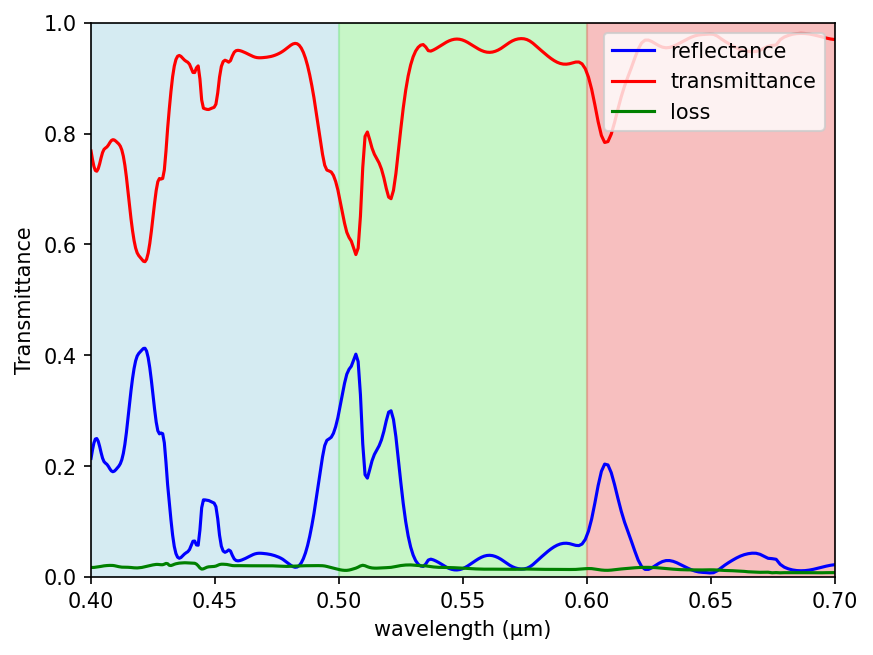

In [35]:
wl = []
Rs = []
Ts = []
for i in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[i] * um_scale))
    Rs = np.append(Rs, -refl_flux[i] / total_flux[i])
    Ts = np.append(Ts, tran_flux[i] / total_flux[i])

if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, Rs, "b", label="reflectance")
    plt.plot(wl, Ts, "r", label="transmittance")
    plt.plot(wl, 1 - Rs - Ts, "g", label="loss")
    #plt.axis([5.0, 10.0, 0, 1])
    plt.axis([0.40, 0.70, 0, 1])
    plt.xlabel("wavelength (μm)")
    plt.ylabel("Transmittance")
    plt.fill([0.40, 0.40, 0.50, 0.50], [0.0, 1.0, 1.0, 0.0], color='lightblue', alpha=0.5)
    plt.fill([0.50, 0.50, 0.60, 0.60], [0.0, 1.0, 1.0, 0.0], color='lightgreen', alpha=0.5)
    plt.fill([0.60, 0.60, 0.70, 0.70], [0.0, 1.0, 1.0, 0.0], color='lightcoral', alpha=0.5)
    plt.legend(loc="upper right")
    # plt.show()
    plt.savefig("TransRefl.png")

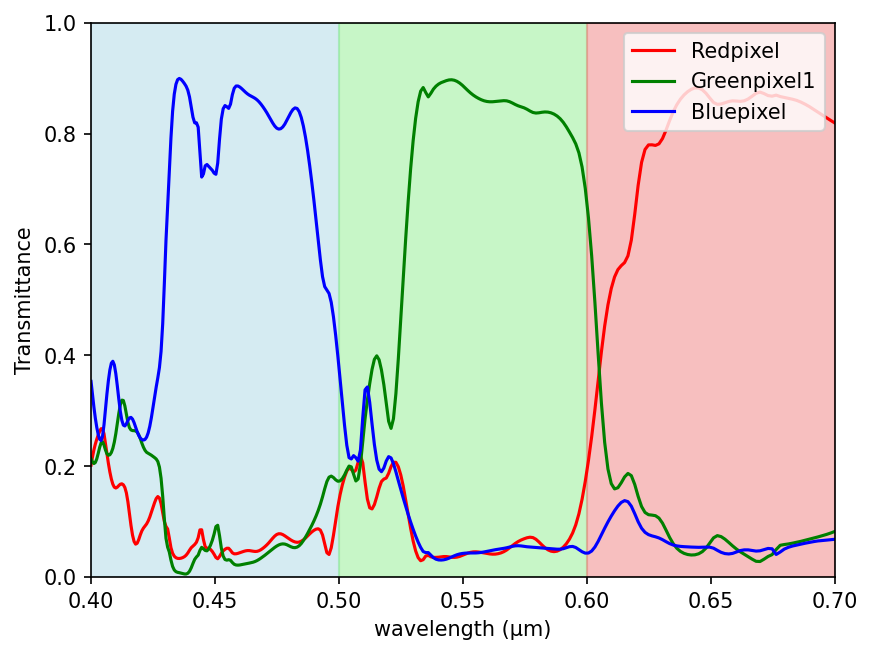

In [36]:
wl = []
Tr = []
Tg = []
Tb = []
for i in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[i] * um_scale))
    Tr = np.append(Tr, red_flux[i] / total_flux[i])
    Tg = np.append(Tg, green_flux[i] / total_flux[i])
    Tb = np.append(Tb, blue_flux[i] / total_flux[i])

if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, Tr, "r", label="Redpixel")
    plt.plot(wl, Tg, "g", label="Greenpixel1")
    plt.plot(wl, Tb, "b", label="Bluepixel")
    
    plt.axis([0.40, 0.70, 0, 1])
    plt.xlabel("wavelength (μm)")
    plt.ylabel("Transmittance")
    plt.fill([0.40, 0.40, 0.50, 0.50], [0.0, 1.0, 1.0, 0.0], color='lightblue', alpha=0.5)
    plt.fill([0.50, 0.50, 0.60, 0.60], [0.0, 1.0, 1.0, 0.0], color='lightgreen', alpha=0.5)
    plt.fill([0.60, 0.60, 0.70, 0.70], [0.0, 1.0, 1.0, 0.0], color='lightcoral', alpha=0.5)
    plt.legend(loc="upper right")
    #plt.show()
    plt.savefig("Transmission.png")

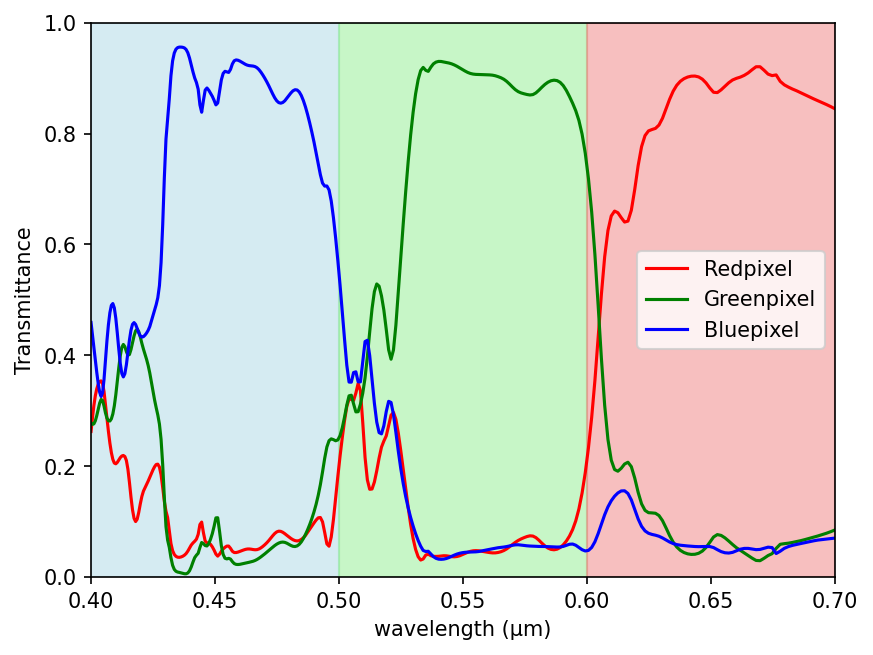

In [37]:
wl = []
Tr = []
Tg = []
Tb = []
Tg0 = []
for i in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[i] * um_scale))
    Tr = np.append(Tr, red_flux[i] / tran_flux[i] )
    Tg = np.append(Tg, green_flux[i] / tran_flux[i] )
    Tb = np.append(Tb, blue_flux[i] / tran_flux[i] )


if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, Tr, "r", label="Redpixel")
    plt.plot(wl, Tg, "g", label="Greenpixel")
    plt.plot(wl, Tb, "b", label="Bluepixel")

    
    plt.axis([0.40, 0.70, 0, 1])
    plt.xlabel("wavelength (μm)")
    plt.ylabel("Transmittance")
    plt.fill([0.40, 0.40, 0.50, 0.50], [0.0, 1.0, 1.0, 0.0], color='lightblue', alpha=0.5)
    plt.fill([0.50, 0.50, 0.60, 0.60], [0.0, 1.0, 1.0, 0.0], color='lightgreen', alpha=0.5)
    plt.fill([0.60, 0.60, 0.70, 0.70], [0.0, 1.0, 1.0, 0.0], color='lightcoral', alpha=0.5)
    plt.legend(loc="right")
    #plt.show()
    plt.savefig("OpricalEffeciency.png")

In [38]:
print(np.mean(Tr[0:66]))
print(np.mean(Tg[66:160]))
print(np.mean(Tb[160:300]))

0.8096039570926419
0.7418878087917169
0.7183177156403795


In [39]:
print(max(Tr[0:66]))
print(max(Tg[66:160]))
print(max(Tb[160:300]))

0.9205565491551498
0.9301470290491404
0.9559748736625957


In [40]:
print(max((Tr - Tg)[0:66]))
print(max((Tg - Tr)[66:160]))
print(max((Tb - Tr)[160:300]))

0.8909953251408864
0.8926543499640435
0.9202964006409673


In [41]:
print(np.mean(Tr[66:300]))

0.11900826751973556


In [42]:
print((sum(Tg[0:66]) + sum(Tg[160:300]))/206)

0.14869111892875525


In [43]:
print(np.mean(Tb[0:160]))

0.11116187198043392
